# HOMEWORK 1: HIDDEN MARKOV MODEL
&ensp; Consider an example of a hidden Markov model. Santa Claus has three bags with gifts in multi-colored packaging: __red__, **green**, **blue**. At night, Santa Claus sneaks into the apartment and secretly puts gifts under the tree in a row, taking one present out of the bag. The next morning we find an ordered sequence of five gifts and want to make the best guess about the sequence of bags from which he got these gifts. Santa Claus with bags - **hidden Markov model**. At the same time, $3$ colors - the space of $K$ possible events, $2$ bags - the number of states $M$, 5 gifts - our $L$  observations, each of which is represented by a number - color number - from $0$ to $2$. We know what are the chances that Santa Claus will start to get gifts from bag with number $i$ - vector $\pi(i)$. We also know the transition matrix $A$, what is the probability that Santa Claus moves from bag with number $i$ to bag with number $j$. The bags of Santa Claus are endless, but we know exactly what the color ratio of the gifts in each bag was loaded at the factory in Veliky Ustyug. This is the probability matrix for emission $B$.

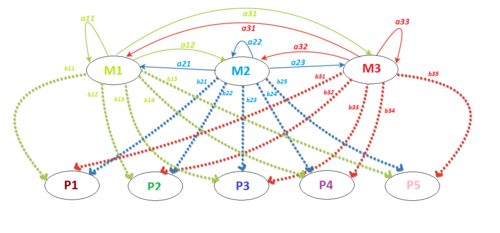

### To find the best solution, we use the following algorithm:

* Set transition (MxM) and emission (MxK) matrices and beginning distribution
(vector of length M).
* HMM random generator: generate a sequence x of length L given the model parameters.
* Use Viterbi algorithm to find the most probable path Pi given x and HMM parameters.
* Find the probability P(x) using forward algorithm (store the full matrix of forward probabilities fk(xi) in order to use it for posterior decoding later on).
* Implement the backward algorithm.
* Implement posterior decoding.
* Implement Baum-Welch training.


## Set transition (MxM) and emission (MxK) matrices and beginning distribution
We set the probabilities of transition from one box to another and also fill the emission matrix with probabilities

In [1]:
import numpy as np
import pandas as pd  # only for displaying matrices
from viterbi import viterbii
from hmmlearn import hmm
from forward_and_back_algorithm import forward, backward, likelihood, posterior_prob, pbwd
import matplotlib.pyplot as plt
from baum_welch import baum_post, gamma, epsillon, baum_welch_trans, baum_welch_emmis
%matplotlib inline

# transition
m = 2 # states
# for more realitiness
'''paa1 = np.random.random()
pab1 = np.random.random()
pabc = 1 / (paa1 + pab1)
paa = pabc * paa1
pab = pabc * pab1
pba1 = np.random.random()
pbb1 = np.random.random()
pbac = 1 / (pba1 + pbb1)
pba = pba1 * pbac
pbb = pbb1 * pbac'''
paa = 0.4
pab = 0.6
pba = 0.2
pbb = 0.8
#L = int(input('Enter a length of a sequence: '))
L = 100 # length of the visible sequence
iterations = 200
sequence = []
boxes = ['Box 1', 'Box 2']
boxes_prob = np.array([0.5, 0.5]) # probabilities at the first iteration for sequence

transition_matrix = np.array([[paa, pab], [pba, pbb]])
transition_matrix1 = pd.DataFrame(transition_matrix, columns=boxes, index=boxes)
print('\nTRANSITION MATRIX', transition_matrix1, sep='\n ')

# emission
'''x11 = np.random.random()
x13 = np.random.random()
aa = 1 / (x11 + x12 + x13)
a11 = x11 * aa
a12 = x12 * aa
a13 = x13 * aa
x21 = np.random.random()
x22 = np.random.random()
x23 = np.random.random()
aa1 = 1 / (x21 + x22 + x23)
a21 = x21 * aa1
a22 = x22 * aa1
a23 = x23 * aa1''' # we can do it later
a11 = 0.2
a12 = 0.5
a13 = 0.3
a21 = 0.6
a22 = 0.3
a23 = 0.1
events = np.array(['Red', 'Green', 'Blue'])
nevents = 3
emission_matrix = np.array([[a11, a12, a13], [a21, a22, a23]])
emission_matrix1 = pd.DataFrame(emission_matrix, columns=events, index=boxes)
print('\nEMISSION MATRIX', emission_matrix1, sep='\n ')


TRANSITION MATRIX
        Box 1  Box 2
Box 1    0.4    0.6
Box 2    0.2    0.8

EMISSION MATRIX
        Red  Green  Blue
Box 1  0.2    0.5   0.3
Box 2  0.6    0.3   0.1


## HMM random generator: generate a sequence x of length L given the model parameters


In [2]:
# randomize and sequence
# it's a random generator for building a visible sequence taking into account probability matrices
counter_for_boxes = []
count0 = np.random.random()
if 0 <= count0 <= boxes_prob[0]:
    b = 0  # it says which box we are into right now
else:
    b = 1
counter_for_boxes.append(b)
check = np.random.random()
if 0 <= check <= emission_matrix[b, 0]:
    sequence.append([events[0], 0])
elif emission_matrix[b, 0] < check <= emission_matrix[b, 1]:
    sequence.append([events[1], 1])
else:
    sequence.append([events[2], 2])

# b for current box
for i in range(1, L):
    count = np.random.random()
    if 0 <= count < transition_matrix[b, 0]:
        b = 0
    elif transition_matrix[b, 0] <= count <= 1:
        b = 1
    counter_for_boxes.append(b)
    check1 = np.random.random()
    if 0 <= check1 <= emission_matrix[b, 0]:
        sequence.append([events[0], 0])
    elif emission_matrix[b, 0] < check1 <= emission_matrix[b, 1]:
        sequence.append([events[1], 1])
    else:
        sequence.append([events[2], 2])

print('\n VISIBLE OUTCOMES:\n', sequence)
print('\n INVISIBLE OUTCOMES(our prediction):\n', counter_for_boxes, '\n')



 VISIBLE OUTCOMES:
 [['Green', 1], ['Blue', 2], ['Red', 0], ['Blue', 2], ['Red', 0], ['Red', 0], ['Blue', 2], ['Blue', 2], ['Blue', 2], ['Blue', 2], ['Blue', 2], ['Red', 0], ['Blue', 2], ['Red', 0], ['Blue', 2], ['Red', 0], ['Red', 0], ['Red', 0], ['Blue', 2], ['Blue', 2], ['Blue', 2], ['Blue', 2], ['Red', 0], ['Blue', 2], ['Red', 0], ['Red', 0], ['Blue', 2], ['Blue', 2], ['Red', 0], ['Green', 1], ['Green', 1], ['Blue', 2], ['Blue', 2], ['Blue', 2], ['Blue', 2], ['Red', 0], ['Green', 1], ['Red', 0], ['Red', 0], ['Red', 0], ['Red', 0], ['Red', 0], ['Blue', 2], ['Red', 0], ['Red', 0], ['Red', 0], ['Blue', 2], ['Green', 1], ['Blue', 2], ['Red', 0], ['Red', 0], ['Red', 0], ['Blue', 2], ['Blue', 2], ['Red', 0], ['Blue', 2], ['Blue', 2], ['Red', 0], ['Blue', 2], ['Red', 0], ['Red', 0], ['Green', 1], ['Red', 0], ['Red', 0], ['Red', 0], ['Blue', 2], ['Blue', 2], ['Red', 0], ['Blue', 2], ['Red', 0], ['Red', 0], ['Blue', 2], ['Red', 0], ['Red', 0], ['Blue', 2], ['Red', 0], ['Blue', 2], ['Green'

## Use Viterbi algorithm to find the most probable path Pi given x and HMM parameters
&nbsp; Define the Viterbi function with variables:  
&emsp; seq - the visible sequence;  
&emsp; pi - the initial probabilities for transition from one box to another;  
&emsp; e - the emission matrix;  
&emsp; t - the transition matrix;  
&emsp; m - states;   
&emsp; l - the lenghth of the visible sequence  

In [4]:
def viterbii(seq, pi, e, t, m, l):
    v = np.zeros((l, m))
    psi = np.zeros((l, m))  # нужен далее для отыскания скрытой последовательности
    for j in range(m):
        v[0, j] = e[j, seq[0][1]] * pi[j]
    for i in range(1, l):
        for j in range(m):
            v[i, j] = max(v[i - 1] * t[:, j]) * e[j, seq[i][1]]  # перемножаются строка и стоблец
            psi[i, j] = np.argmax(v[i - 1] * t[:, j])  # перемножаются стока и стоблец

    return v, psi


# viterbi algorithm
hid = viterbii(sequence, boxes_prob, emission_matrix, transition_matrix, m, L)[0]
hid_seq = np.argmax(hid, axis=1)  # искомая последовательность скрытых состояний
print('\n VITERBI ALGORITHM\n', hid_seq, '\n')


 VITERBI ALGORITHM
 [0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1] 



## Find the probability P(x) using forward algorithm (store the full matrix of forward probabilities fk(xi) in order to use it for posterior decoding later on)

&ensp; The forward algorithm, in the context of a hidden Markov model (HMM), is used to calculate a 'belief state': the probability of a state at a certain time, given the history of evidence. The process is also known as filtering.  

For an HMM such as this one: 

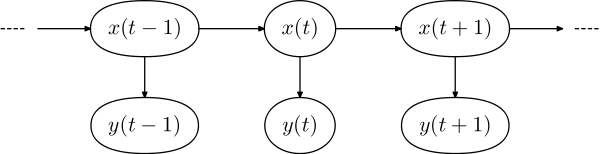

this probability is written as ${\displaystyle P(x_{t}|y_{1:t})}$. Here ${\displaystyle x(t)}$ is the hidden state which is abbreviated as ${\displaystyle x_{t}}$ and ${\displaystyle y_{1:t}}$ are the observations $1$ to $t$. A belief state can be calculated at each time step, but doing this does not, in a strict sense, produce the most likely state sequence, but rather the most likely state at each time step, given the previous history. 

The next important problem is to find the probability $P(x)$ of the
observed sequence $x$

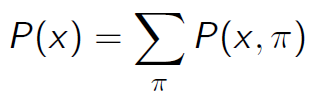

The number of paths $\pi$ grows exponentially with the length L of x,
so the brute force solution is practically useless.
Define forward probability:

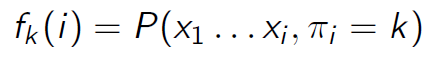

### _forward algorithm_

* Initialisation $(i = 0): f_{0}(0) = 1; f_{k}(0) = 0$ for $k > 0$ (the begin state). 


* Recursion $(i = 1, 2, ..., L): f_{l}(i) = e_{l}(x_i)\sum_{k}{f_{k}(i - 1)a_{k}{l}}$


* Termintation: $P(x) = \sum_{k}{f_{k}(L)}$

In [5]:
def forward(obs, pi, t, e, m, l):
    fwd = np.zeros((l, m))

    fwd[0, 0] = 1

    for i in range(1, l):
        for l in range(m):
            for k in range(m):
                fwd[i, l] += fwd[i - 1, k] * t[k, l]
            fwd[i, l] *= e[l, obs[i][1]]

    return fwd


def likelihood(obs_seq, pi, t, e, m, l):
    # returns log P(Y  \mid  model)
    # using the forward part of the forward-backward algorithm
    return forward(obs_seq, pi, t, e, m, l)[-1].sum()

## Implement the backward algorithm

What is the probability that the path's ith state is $k$ given the
sequence $x$? To begin with,

$$P(x, \pi_{i} = k) = P(x_1 ... x_i, \pi_{i} = k)P(x_{i + 1} ... x_L|x_1 ... x_i, \pi_{i} = k) = P(x_1 ... x_i, \pi_{i} = k)P(x_{i + 1} ... x_L, \pi_{i} = k)$$

Denote

$$b_{k}(i) = P(x_{i + 1} ... x_L, \pi_{i} = k)$$

it is called _backward probability_. The algorithm to compute $b_{k}(i)$
is almost identical to the forward algorithm.

### _backward algorithm_

* Initialisation $(i = 0): bk (L) = 1 for all k$


* Recursion $(i = L - 1, L - 2, ..., 1): b_{k}(i) = \sum_{l}{a_{k}{l} e_{l} (x_{i + 1})} b_{l}(i + 1)$


* Termination: $P(x) = \sum_{l}{a_{0}{l} e_{l} (x_1) b_{i}(1)}$ 

In [6]:
def backward(obs, t, e, m, l):
    bwd = np.zeros((l, m))

    for j in range(m):
        bwd[l - 1, j] = 1

    for i in range(l - 2, -1, -1):
        for k in range(m):
            for l in range(m):
                bwd[i, k] += bwd[i + 1, l] * t[k, l] * e[l, obs[i + 1][1]]

    return bwd

def pbwd(obs, t, e, m, l):
    bwdp = 0
    bwd = backward(obs, t, e, m, l)
    for l in range(m):
        bwdp += bwd[1, l] * t[0, l] * e[l, obs[1][1]]
    return bwdp

### Now we can print forward, backward algorithms results with its probabilities

In [7]:
print('\nFORWARD ALGORITHM:\n', forward(sequence, boxes_prob, transition_matrix, emission_matrix, m, L), '\n')

print('\nBACKWARD ALGORITHM:\n', backward(sequence, transition_matrix, emission_matrix, m, L), '\n')

print('\nP(X), forward:\n', likelihood(sequence, boxes_prob, transition_matrix, emission_matrix, m, L), '\n')

print('P(X), backward:\n', pbwd(sequence, transition_matrix, emission_matrix, m, L))


FORWARD ALGORITHM:
 [[1.00000000e+00 0.00000000e+00]
 [1.20000000e-01 6.00000000e-02]
 [1.20000000e-02 7.20000000e-02]
 [5.76000000e-03 6.48000000e-03]
 [7.20000000e-04 5.18400000e-03]
 [2.64960000e-04 2.74752000e-03]
 [1.96646400e-04 2.35699200e-04]
 [3.77395200e-05 3.06547200e-05]
 [6.36802560e-06 4.71674880e-06]
 [1.04716800e-06 7.59421440e-07]
 [1.71225446e-07 1.23583795e-07]
 [1.86413875e-08 1.20961382e-07]
 [9.49464945e-09 1.07953938e-08]
 [1.19138771e-09 8.59986285e-09]
 [6.58958296e-10 7.59472290e-10]
 [8.30955553e-11 6.01771686e-10]
 [3.07185119e-11 3.18764809e-10]
 [1.52080733e-11 1.64065773e-10]
 [1.16689152e-11 1.40377462e-11]
 [2.24253459e-12 1.82315461e-12]
 [3.78493427e-13 2.80404444e-13]
 [6.22434779e-14 4.51419612e-14]
 [6.78515668e-15 4.40757934e-14]
 [3.45876641e-15 3.93317287e-15]
 [4.34028227e-16 3.13307889e-15]
 [1.60045414e-16 1.66012803e-15]
 [1.18813131e-16 1.42412967e-16]
 [2.28023538e-17 1.85218252e-17]
 [2.56506131e-18 1.70993235e-17]
 [2.22294461e-18 4.565

## Implement posterior decoding

Now we are ready to answer the initial question:

$$P(\pi_i = k | x) = \dfrac{P(x, \pi_i = k)}{P(x)} = \dfrac{f_{k}(i) b_{k}(i)}{P(x)}$$

In [8]:
def posterior_prob(obs, pi, t, e, m, l):
    ps = np.zeros((l, m))
    forw = forward(obs, pi, t, e, m, l)
    backw = backward(obs, t, e, m, l)
    like = likelihood(obs, pi, t, e, m, l)
    for i in range(l):
        for j in range(m):
            ps[i, j] = forw[i][j] * backw[i][j] / like
    return ps

print('\nPOSTERIOR PROBABILITY:\n', posterior_prob(sequence, boxes_prob, transition_matrix, emission_matrix, m, L), '\n')


POSTERIOR PROBABILITY:
 [[1.         0.        ]
 [0.63405905 0.36594095]
 [0.17029524 0.82970476]
 [0.4261257  0.5738743 ]
 [0.10885709 0.89114291]
 [0.11797862 0.88202138]
 [0.53619215 0.46380785]
 [0.62941218 0.37058782]
 [0.64622549 0.35377451]
 [0.63146753 0.36853247]
 [0.54578376 0.45421624]
 [0.16068411 0.83931589]
 [0.43241397 0.56758603]
 [0.14559703 0.85440297]
 [0.41905228 0.58094772]
 [0.1034197  0.8965803 ]
 [0.07812446 0.92187554]
 [0.11382295 0.88617705]
 [0.53418157 0.46581843]
 [0.62464188 0.37535812]
 [0.6264314  0.3735686 ]
 [0.54432217 0.45567783]
 [0.15935625 0.84064375]
 [0.42342191 0.57657809]
 [0.1082874  0.8917126 ]
 [0.1153439  0.8846561 ]
 [0.50857024 0.49142976]
 [0.51453301 0.48546699]
 [0.14913292 0.85086708]
 [0.3702517  0.6297483 ]
 [0.45495492 0.54504508]
 [0.61104779 0.38895221]
 [0.64185811 0.35814189]
 [0.62954672 0.37045328]
 [0.54128327 0.45871673]
 [0.14169856 0.85830144]
 [0.2887658  0.7112342 ]
 [0.09107401 0.90892599]
 [0.07308296 0.92691704]


## Implement Baum-Welch training


* _Initialisation:_ assign random values to model parameters $\theta = (A, B, \pi)$, or use the best prior estimate.


* _Recurrence:_
    * &emsp; Calculate $f_{k}(i)$ for sequence $x$ under HMM with parameters    $\theta$ using forward algorithm.
    * &emsp; Calculate $b_{k}(i)$ using backward algorithm.
    * &emsp; Calculate $A_{kl}$ and $E_k$ .
    * &emsp; Update model parameters $\theta$
    
        $$ a_{kl} = \dfrac{A_{kl}}{\sum_{m}A_{kl}} $$
        
        $$ e_{k}(b) = \dfrac{E_{k}(b)}{\sum_{b'}E_{k}(b')} $$
        
* _Termination:_ Stop if the change in log likelihood is less than some prededefined threshold or the maximum number of iterations is exceeded.

### _Algorithm:_

#### Forward procedure

Let $\alpha_i(t) = P ( Y_1 = y_1 , … , Y_t = y_t , X_t = i ∣ \theta )$, the probability of seeing the observations $y_1 , y_2 , … , y_t$ and being in state $i at time t$. We calculate $\beta_i(t)$ as,


1. $\alpha_i(1) = \pi_i b_i(y_1)$,
2. $\alpha_i(t) = b_i(y_{t + 1}) \sum_{j = 1}^N \alpha_j(t) a_{ji}$


#### Backward procedure

Let $\beta_i(t) = P (Y_1 = y_1 , … , Y_t = y_t | X_t = i, \theta )$ that is the probability of the ending partial sequence $y_t + 1 , … , y_T$ given starting state $i$ at time $t$. We calculate $\beta_i(t)$ as, 

1. $\beta_i(T) = 1$,
2. $\beta_i(t) = \sum_{j = 1}^N \beta_j(t + 1) a_{ij} b_j(y_{t + 1})$


#### Update

We can now calculate the temporary variables:
We can now calculate the temporary variables, according to Bayes' theorem:
$${\displaystyle \gamma _{i}(t)=P(X_{t}=i\mid Y,\theta )={\frac {P(X_{t}=i,Y\mid \theta )}{P(Y\mid \theta )}}={\frac {\alpha _{i}(t)\beta _{i}(t)}{\sum _{j=1}^{N}\alpha _{j}(t)\beta _{j}(t)}}}$$

which is the probability of being in state $i$ at time $t$ given the observed sequence $Y$ and the parameters $\theta$

$${\displaystyle \xi _{ij}(t)=P(X_{t}=i,X_{t+1}=j\mid Y,\theta )={\dfrac {P(X_{t}=i,X_{t+1}=j,Y\mid \theta )}{P(Y\mid \theta )}}={\dfrac {\alpha _{i}(t)a_{ij}\beta _{j}(t+1)b_{j}(y_{t+1})}{\sum _{i=1}^{N}\sum _{j=1}^{N}\alpha _{i}(t)a_{ij}\beta _{j}(t+1)b_{j}(y_{t+1})}}}$$


which is the probability of being in state $i$ and $j$ at times $t$ and $t + 1$ respectively given the observed sequence $Y$ and parameters $\theta$.

The denominators of $\gamma _{i}(t)$ and $\xi _{ij}(t)$ are the same; they represent the probability of making the observation $Y$ given the parameters $\theta$.

The parameters of the hidden Markov model $\theta$ can now be updated:

$\pi _{i}^{*}=\gamma _{i}(1)$

which is the expected frequency spent in state $i$ at time $1$.
 
$a_{ij}^{*}={\dfrac {\sum _{t=1}^{T-1}\xi _{ij}(t)}{\sum _{t=1}^{T-1}\gamma _{i}(t)}}$

which is the expected number of transitions from state $i$ to state $j$ compared to the expected total number of transitions away from state $i$. To clarify, the number of transitions away from state $i$ does not mean transitions to a different state $j$, but to any state including itself. This is equivalent to the number of times state $i$ is observed in the sequence from $t = 1$ to $t = T − 1$.

$b_{i}^{*}(v_{k})={\dfrac {\sum _{t=1}^{T}1_{y_{t}=v_{k}}\gamma _{i}(t)}{\sum _{t=1}^{T}\gamma _{i}(t)}}$

where

$1_{y_{t}=v_{k}}={\begin{cases}1&{\text{if }}y_{t}=v_{k},\\0&{\text{otherwise}}\end{cases}}$

is an indicator function, and $b_{i}^{*}(v_{k})$ is the expected number of times the output observations have been equal to $v_{k}$ while in state $i$ over the expected total number of times in state $i$.

These steps are now repeated iteratively until a desired level of convergence. In our case it repeats for _iterations_ are over

#### Let's code it!

In [9]:
# from hmmlearn we get:
model = hmm.MultinomialHMM(n_components=m)
model.startprob_ = boxes_prob
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix
X = model.sample(L)

#    redife visual sequence in hmm to our visible sequence
for i in range(L):
    X[0][i] = sequence[i][1]
    
print('\nPOSTERIOR PROBABILITY FROM HMMLEARN:\n', model.predict_proba(X[0]))


POSTERIOR PROBABILITY FROM HMMLEARN:
 [[0.67432226 0.32567774]
 [0.55582817 0.44417183]
 [0.16076742 0.83923258]
 [0.42383542 0.57616458]
 [0.10863904 0.89136096]
 [0.11794984 0.88205016]
 [0.53618567 0.46381433]
 [0.62941072 0.37058928]
 [0.64622516 0.35377484]
 [0.63146745 0.36853255]
 [0.54578374 0.45421626]
 [0.16068411 0.83931589]
 [0.43241397 0.56758603]
 [0.14559703 0.85440297]
 [0.41905228 0.58094772]
 [0.1034197  0.8965803 ]
 [0.07812446 0.92187554]
 [0.11382295 0.88617705]
 [0.53418157 0.46581843]
 [0.62464188 0.37535812]
 [0.6264314  0.3735686 ]
 [0.54432217 0.45567783]
 [0.15935625 0.84064375]
 [0.42342191 0.57657809]
 [0.1082874  0.8917126 ]
 [0.1153439  0.8846561 ]
 [0.50857024 0.49142976]
 [0.51453301 0.48546699]
 [0.14913292 0.85086708]
 [0.3702517  0.6297483 ]
 [0.45495492 0.54504508]
 [0.61104779 0.38895221]
 [0.64185811 0.35814189]
 [0.62954672 0.37045328]
 [0.54128327 0.45871673]
 [0.14169856 0.85830144]
 [0.2887658  0.7112342 ]
 [0.09107401 0.90892599]
 [0.0730829

In [10]:
#   forward algorithm
def forward(obs, pi, t, e, m, l):
    alpha = np.zeros((l, m))

    for k in range(m):  # задаем начальные параметры для дальнейшего их улучшения
        alpha[0, k] = pi[k] * e[k, obs[0][1]]

#   рекурсивно получаем следющиее элементы aplha
    for i in range(1, l):
        for l in range(m):
            for k in range(m):
                alpha[i, l] += alpha[i - 1, k] * t[k, l]
            alpha[i, l] *= e[l, obs[i][1]]

    return alpha


#   define the P(x)
def prob_x(obs, pi, t, e, m, l):
    # returns log P(Y  \mid  model)
    # using the forward part of the forward-backward algorithm
    return forward(obs, pi, t, e, m, l)[-1].sum()


#   backward algorithm
def backward(obs, t, e, m, l):
    beta = np.zeros((l, m))

    for k in range(m):
        beta[l - 1, k] = 1

    for i in range(l - 2, -1, -1):
        for k in range(m):
            for l in range(m):
                beta[i, k] += beta[i + 1, l] * t[k, l] * e[l, obs[i + 1][1]]

    return beta


#   update variables
def baum_post(obs, pi, t, e, m, l):
    alpha = forward(obs, pi, t, e, m, l)
    beta = backward(obs, t, e, m, l)
    prob = prob_x(obs, pi, t, e, m, l)
    posterior = np.zeros((l, m))

    for i in range(l):
        for k in range(m):
            posterior[i, k] = alpha[i, k] * beta[i, k] / prob
    return posterior


def gamma(obs, pi, t, e, m, l):
    alpha = forward(obs, pi, t, e, m, l)
    beta = backward(obs, t, e, m, l)
    g = np.zeros((l, m))
    summ = 0
    for y in range(l):
        for i in range(m):
            summ = 0
            for j in range(m):
                summ += alpha[y, j] * beta[y, j]
            g[y, i] = (alpha[y, i] * beta[y, i]) / summ
    return g


def epsillon(obs, pi, t, e, m, l):

    alpha = forward(obs, pi, t, e, m, l)
    beta = backward(obs, t, e, m, l)
    eps = np.zeros((l, m, m))

    summ0 = 0
    for k in range(l):
        summ0 = 0
        for i in range(m):
            for j in range(m):
                summ0 += alpha[k - 1, i] * t[i, j] * beta[k, j] * e[j, obs[k][1]]
        for i in range(m):
            for j in range(m):
                eps[k - 1, i, j] = (alpha[k - 1, i] * t[i, j] * beta[k, j] * e[j, obs[k][1]]) / summ0

    return eps


def baum_welch_trans(obs, pi, t, e, m, l):
    global transition_matrix, boxes_prob
    gamm = gamma(obs, pi, t, e, m, l)
    epsi = epsillon(obs, pi, t, e, m, l)

    for i in range(m):
        pi[i] = gamm[0, i]

    sumeps = 0
    sumgam = 0
    for i in range(m):
        for j in range(m):
            sumeps = 0
            sumgam = 0
            for k in range(l - 1):
                sumeps += epsi[k, i, j]
                sumgam += gamm[k, i]
            t[i, j] = sumeps / sumgam
    transition_matrix = t
    return t


def baum_welch_emmis(obs, pi, t, e, m, l):

    global emission_matrix
    gamm = gamma(obs, pi, t, e, m, l)
    em = np.zeros((m, m + 1))
    summg = 0
    summgall = 0
    for i in range(m):
        for j in range(l):
            summg = 0
            summgall = 0
            for k in range(l):
                if obs[k][1] == obs[j][1]:
                    delt = 1
                else:
                    delt = 0
                summg = summg + delt * gamm[k, i]
                summgall += gamm[k, i]
            em[i, obs[j][1]] = summg / summgall

    e = em
    emission_matrix = e
    return e

print('\nPOSTERIOR PROBABILITY(BW):\n', baum_post(sequence, boxes_prob, transition_matrix, emission_matrix, m, L), '\n')


POSTERIOR PROBABILITY(BW):
 [[0.67432226 0.32567774]
 [0.55582817 0.44417183]
 [0.16076742 0.83923258]
 [0.42383542 0.57616458]
 [0.10863904 0.89136096]
 [0.11794984 0.88205016]
 [0.53618567 0.46381433]
 [0.62941072 0.37058928]
 [0.64622516 0.35377484]
 [0.63146745 0.36853255]
 [0.54578374 0.45421626]
 [0.16068411 0.83931589]
 [0.43241397 0.56758603]
 [0.14559703 0.85440297]
 [0.41905228 0.58094772]
 [0.1034197  0.8965803 ]
 [0.07812446 0.92187554]
 [0.11382295 0.88617705]
 [0.53418157 0.46581843]
 [0.62464188 0.37535812]
 [0.6264314  0.3735686 ]
 [0.54432217 0.45567783]
 [0.15935625 0.84064375]
 [0.42342191 0.57657809]
 [0.1082874  0.8917126 ]
 [0.1153439  0.8846561 ]
 [0.50857024 0.49142976]
 [0.51453301 0.48546699]
 [0.14913292 0.85086708]
 [0.3702517  0.6297483 ]
 [0.45495492 0.54504508]
 [0.61104779 0.38895221]
 [0.64185811 0.35814189]
 [0.62954672 0.37045328]
 [0.54128327 0.45871673]
 [0.14169856 0.85830144]
 [0.2887658  0.7112342 ]
 [0.09107401 0.90892599]
 [0.07308296 0.926917

Now let's import functions from _hmmlearn_ module

Calculate Baum-Welch algorithm. Find a new _transition_ and _emission_ matrices

In [11]:
#   find answer
trans = []
emiss = []

for i in range(iterations):
    anew = baum_welch_trans(sequence, boxes_prob, transition_matrix, emission_matrix, m, L)
    bnew = baum_welch_emmis(sequence, boxes_prob, transition_matrix, emission_matrix, m, L)

    print('\n', anew, '\n', '\n', bnew, '\n')

new_trans = anew
new_emiss = bnew
print('\nNEW TRANSITION:\n', new_trans)
print('\nNEW EMISSION:\n', new_emiss)

h = viterbii(sequence, boxes_prob, new_emiss, new_trans, m, L)[0] #  use Viterbi algorithm to find true hidden sequence
hhbw = np.argmax(h, axis=1)


 [[0.45864238 0.54135762]
 [0.25195447 0.74804553]] 
 
 [[0.18509737 0.10669431 0.70820832]
 [0.64379668 0.0637159  0.29248742]] 


 [[0.46142724 0.53857276]
 [0.26364246 0.73635754]] 
 
 [[0.17481574 0.1188046  0.70637966]
 [0.62506531 0.05961528 0.3153194 ]] 


 [[0.45397397 0.54602603]
 [0.26583228 0.73416772]] 
 
 [[0.17199947 0.13231565 0.69568488]
 [0.62002271 0.05366268 0.32631461]] 


 [[0.44511224 0.55488776]
 [0.26561088 0.73438912]] 
 
 [[0.17009964 0.14570625 0.6841941 ]
 [0.61742502 0.04770012 0.33487486]] 


 [[0.43615436 0.56384564]
 [0.26433788 0.73566212]] 
 
 [[0.16811409 0.15856785 0.67331807]
 [0.61500458 0.04226158 0.34273384]] 


 [[0.42720498 0.57279502]
 [0.26229936 0.73770064]] 
 
 [[0.1659672  0.17088525 0.66314755]
 [0.61240527 0.03743045 0.35016428]] 


 [[0.41825261 0.58174739]
 [0.25959719 0.74040281]] 
 
 [[0.16368783 0.18275537 0.6535568 ]
 [0.60961142 0.033166   0.35722257]] 


 [[0.40930255 0.59069745]
 [0.25629958 0.74370042]] 
 
 [[0.16129807 0.1942


 [[0.12590742 0.87409258]
 [0.06536271 0.93463729]] 
 
 [[9.29886423e-04 9.89094758e-01 9.97535589e-03]
 [5.10523276e-01 1.46270501e-03 4.88014019e-01]] 


 [[0.12572606 0.87427394]
 [0.0652911  0.9347089 ]] 
 
 [[7.99443533e-04 9.90414221e-01 8.78633514e-03]
 [5.10487946e-01 1.43913492e-03 4.88072919e-01]] 


 [[0.12556799 0.87443201]
 [0.06523054 0.93476946]] 
 
 [[6.87209093e-04 9.91574779e-01 7.73801191e-03]
 [5.10458002e-01 1.41596215e-03 4.88126036e-01]] 


 [[0.12543034 0.87456966]
 [0.06517965 0.93482035]] 
 
 [[5.90666535e-04 9.92595334e-01 6.81399913e-03]
 [5.10432790e-01 1.39317807e-03 4.88174032e-01]] 


 [[0.12531058 0.87468942]
 [0.06513719 0.93486281]] 
 
 [[5.07640399e-04 9.93492605e-01 5.99975443e-03]
 [5.10411734e-01 1.37077460e-03 4.88217491e-01]] 


 [[0.12520651 0.87479349]
 [0.06510209 0.93489791]] 
 
 [[4.36251851e-04 9.94281360e-01 5.28238794e-03]
 [5.10394325e-01 1.34874411e-03 4.88256931e-01]] 


 [[0.12511619 0.87488381]
 [0.06507341 0.93492659]] 
 
 [[3.748


 [[0.12472361 0.87527639]
 [0.0653841  0.9346159 ]] 
 
 [[2.24613504e-07 9.99990719e-01 9.05678702e-06]
 [5.10561280e-01 6.04214607e-04 4.88834505e-01]] 


 [[0.12472784 0.87527216]
 [0.06539274 0.93460726]] 
 
 [[1.93149898e-07 9.99991830e-01 7.97670782e-06]
 [5.10566121e-01 5.94648255e-04 4.88839231e-01]] 


 [[0.12473202 0.87526798]
 [0.06540126 0.93459874]] 
 
 [[1.66096714e-07 9.99992808e-01 7.02553526e-06]
 [5.10570889e-01 5.85235058e-04 4.88843876e-01]] 


 [[0.12473615 0.87526385]
 [0.06540964 0.93459036]] 
 
 [[1.42835254e-07 9.99993669e-01 6.18787112e-06]
 [5.10575585e-01 5.75972511e-04 4.88848442e-01]] 


 [[0.12474022 0.87525978]
 [0.0654179  0.9345821 ]] 
 
 [[1.22833683e-07 9.99994427e-01 5.45015830e-06]
 [5.10580210e-01 5.66858150e-04 4.88852932e-01]] 


 [[0.12474424 0.87525576]
 [0.06542603 0.93457397]] 
 
 [[1.05634823e-07 9.99995094e-01 4.80046044e-06]
 [5.10584764e-01 5.57889556e-04 4.88857347e-01]] 


 [[0.12474821 0.87525179]
 [0.06543403 0.93456597]] 
 
 [[9.084


 [[0.12488033 0.87511967]
 [0.06569709 0.93430291]] 
 
 [[7.69551155e-11 9.99999989e-01 1.09811180e-08]
 [5.10736674e-01 2.60127692e-04 4.89003198e-01]] 


 [[0.12488221 0.87511779]
 [0.06570082 0.93429918]] 
 
 [[6.62188942e-11 9.99999990e-01 9.67653306e-09]
 [5.10738765e-01 2.56035795e-04 4.89005199e-01]] 


 [[0.12488406 0.87511594]
 [0.06570449 0.93429551]] 
 
 [[5.69809574e-11 9.99999991e-01 8.52698825e-09]
 [5.10740822e-01 2.52008576e-04 4.89007169e-01]] 


 [[0.12488589 0.87511411]
 [0.0657081  0.9342919 ]] 
 
 [[4.90321452e-11 9.99999992e-01 7.51405129e-09]
 [5.10742847e-01 2.48045003e-04 4.89009108e-01]] 


 [[0.12488768 0.87511232]
 [0.06571165 0.93428835]] 
 
 [[4.21925066e-11 9.99999993e-01 6.62148218e-09]
 [5.10744840e-01 2.44144061e-04 4.89011016e-01]] 


 [[0.12488944 0.87511056]
 [0.06571515 0.93428485]] 
 
 [[3.63072194e-11 9.99999994e-01 5.83497235e-09]
 [5.10746801e-01 2.40304751e-04 4.89012894e-01]] 


 [[0.12489118 0.87510882]
 [0.06571859 0.93428141]] 
 
 [[3.124

#### Print all what we have!!!

In [12]:
print('\n FROM HMM LEARN:\n', X[1])

print('\nOUR HIDDEN:\n', counter_for_boxes, '\n')

print('\nBW HIDDEN:\n', hhbw, '\n')


 FROM HMM LEARN:
 [1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1]

OUR HIDDEN:
 [0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1] 


BW HIDDEN:
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1] 



## Fin

#### Let's draw a bars that show us what we get

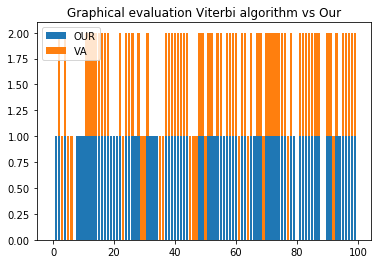

In [13]:
# our prediction vs viterbi
ind = np.arange(L)
p1 = plt.bar(ind, counter_for_boxes)
p2 = plt.bar(ind, hid_seq, bottom=counter_for_boxes)
plt.title('Graphical evaluation Viterbi algorithm vs Our')
plt.legend((p1[0], p2[0]), ('OUR', 'VA'))
plt.show()

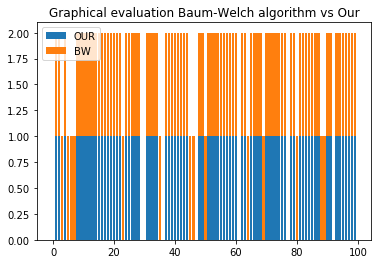

In [14]:
# our prediction vs bw
ind = np.arange(L)
p1 = plt.bar(ind, counter_for_boxes)
p2 = plt.bar(ind, hhbw, bottom=counter_for_boxes)
plt.title('Graphical evaluation Baum-Welch algorithm vs Our')
plt.legend((p1[0], p2[0]), ('OUR', 'BW'))
plt.show()

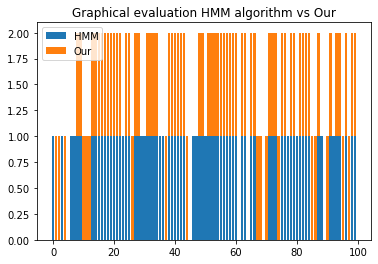

In [17]:
# hmm vs our
ind = np.arange(L)
p1 = plt.bar(ind, X[1])
p2 = plt.bar(ind, counter_for_boxes, bottom=X[1])
plt.title('Graphical evaluation HMM algorithm vs Our')
plt.legend((p1[0], p2[0]), ('HMM', 'Our'))
plt.show()

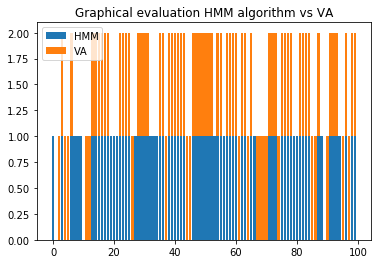

In [18]:
# hmm vs va
ind = np.arange(L)
p1 = plt.bar(ind, X[1])
p2 = plt.bar(ind, hid_seq, bottom=X[1])
plt.title('Graphical evaluation HMM algorithm vs VA')
plt.legend((p1[0], p2[0]), ('HMM', 'VA'))
plt.show()

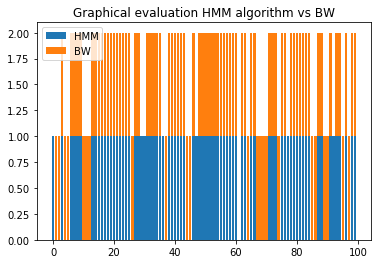

In [19]:
# hmm vs bw
ind = np.arange(L)
p1 = plt.bar(ind, X[1])
p2 = plt.bar(ind, hhbw, bottom=X[1])
plt.title('Graphical evaluation HMM algorithm vs BW')
plt.legend((p1[0], p2[0]), ('HMM', 'BW'))
plt.show()